# Inverted Pendulum Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

In order to deal with potential angle wrap-around issues (i.e. $2\pi = 0$), we
augment the state as follows and use that instead:

$$
\begin{equation*}
\textbf{x}_{augmented} = \begin{bmatrix}
    \sin\theta & \cos\theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The torque is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.pendulum import InvertedPendulumDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.02
pendulum_length = 1.0
dynamics = InvertedPendulumDynamics(dt, l=pendulum_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0]))
Q = np.eye(dynamics.state_size)
Q[0, 1] = Q[1, 0] = pendulum_length
Q[0, 0] = Q[1, 1] = pendulum_length**2
Q[2, 2] = 0.0
Q_terminal = 100 * np.eye(dynamics.state_size)
R = np.array([[0.1]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 300
x0 = dynamics.augment_state(np.array([np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=200, on_iteration=on_iteration)

iteration 0 accepted 1631.9885942957746 [2.85504174 0.75732687]
iteration 1 accepted 1517.143489628173 [2.46144364 0.55473485]
iteration 2 accepted 1479.0607600814183 [2.44242867 0.55008745]
iteration 3 accepted 1441.3794635477593 [2.28568437 0.42552616]
iteration 4 accepted 1343.5735438254874 [2.13368558 0.29539843]
iteration 5 accepted 1246.1371652374485 [1.65307724 0.02119757]
iteration 6 accepted 1242.5152394944184 [ 1.08580616 -0.74784642]
iteration 7 accepted 1201.0177271548018 [ 1.01115265 -0.38671853]
iteration 8 accepted 1173.031263935732 [ 0.76343865 -0.65547982]
iteration 9 accepted 1137.729265663297 [ 0.78525426 -0.29852576]
iteration 10 accepted 1133.3488721265896 [ 0.73708589 -0.18910849]
iteration 11 accepted 1036.4482273938568 [ 0.61101052 -0.19253227]
iteration 12 accepted 1025.9803163724378 [ 0.50260034 -0.30371732]
iteration 13 accepted 1000.7936170682074 [ 0.47218276 -0.2682341 ]
iteration 14 accepted 996.9900815264225 [ 0.44720112 -0.2251096 ]
iteration 15 accepted

iteration 125 accepted 706.7443917685354 [ 0.05869915 -0.0209737 ]
iteration 126 accepted 706.5571047394924 [ 0.05848157 -0.02090742]
iteration 127 accepted 706.5489454715331 [ 0.05747744 -0.02060681]
iteration 128 accepted 706.4250561924468 [ 0.05727419 -0.02054401]
iteration 129 accepted 706.405494807427 [ 0.05663343 -0.02034853]
iteration 130 accepted 706.3982099196744 [ 0.05624541 -0.02022965]
iteration 131 accepted 706.380734315753 [ 0.05586233 -0.02011252]
iteration 132 accepted 706.3196397604721 [ 0.05566882 -0.02005325]
iteration 133 accepted 706.3037519096698 [ 0.05477484 -0.01978423]
iteration 134 accepted 706.3028981099214 [ 0.05442023 -0.01967484]
iteration 135 accepted 706.2875011335659 [ 0.05406766 -0.01956657]
iteration 136 accepted 706.222780917592 [ 0.05388891 -0.01951167]
iteration 137 accepted 706.2217110970338 [ 0.05306288 -0.01926236]
iteration 138 accepted 706.1734857437453 [ 0.05289454 -0.0192102 ]
iteration 139 accepted 706.172257158446 [ 0.05211354 -0.01897267]

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N) * dt
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

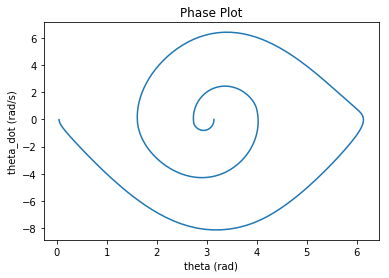

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

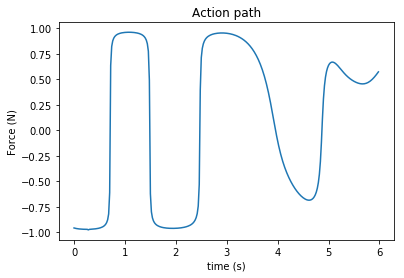

In [13]:
_ = plt.plot(t, us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

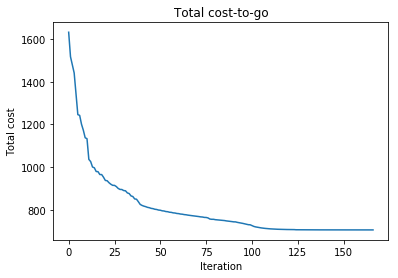

In [14]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")